### Fun with the Instagram API
The aim of this project is to create an app that takes a hashtag, retrieves a specified number of tagged photos from Instagram and merges the images together. Inspired by [this article](https://www.theguardian.com/artanddesign/gallery/2017/may/16/jason-shulman-films-condensed-into-a-single-photo-frame-in-pictures).

In [1]:
import requests
import json
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import app_secrets  # Not part of public repo
%matplotlib inline

App secrets are stored in a separate `app_secrets.py` file which is not part of the public repository.

In [13]:
# App id and secrets are imported from app_secrets.py
client_id = app_secrets.app_secrets["client_id"]
client_secret = app_secrets.app_secrets["client_secret"]

# Arbitrary URL
redirect_uri = "http://localhost:3000/"

# A new browser window will open
url = "https://api.instagram.com/oauth/authorize/?client_id={}&redirect_uri={}&response_type=code&scope=public_content".format(client_id, redirect_uri)
webbrowser.open(url, new=2, autoraise=True)

True

In [3]:
# Visit the URL above and copy the auth code out of the response URL
#
# http://your-redirect-uri?code=CODE
#
# Paste the auth code below

auth_code = "c4309ccd5db14cc4a986e967c51587fc"

In [4]:
# Use the auth_code to request access token using a POST request
oauth_data = {"client_id": client_id,
              "client_secret": client_secret,
              "grant_type": "authorization_code",
              "redirect_uri": redirect_uri,
              "code": auth_code}

token = requests.post("https://api.instagram.com/oauth/access_token", data = oauth_data)

access_token = json.loads(token.content)["access_token"]

In [5]:
# Function to request photos

def get_photos_by_tag(tag, count = 10):
    
    result = []
    
    endpoint = "https://api.instagram.com/v1/tags/{}/media/recent".format(tag)
    
    params = {"access_token": access_token,
              "count": count}
    
    json_response = requests.get(endpoint, params=params)
    
    response = json.loads(json_response.content)["data"]
    
    if len(response) > 0:
        
        print("{} photos found".format(len(response)))
        
        for photo in response:
            p = photo["images"]["standard_resolution"]
            photo_url = p["url"]
            with requests.get(photo_url) as url:
                p["object"] = io.BytesIO(url.content)
            
            result.append(p)
    else:
        print("No photos found")
    
    return result


In [9]:
# Retrieve images
images = get_photos_by_tag("ishootfilm")

2 photos found


In [10]:
# Merge images

n_photos = len(images)
# Create array of floats to store the image
arr = np.zeros((640, 640, 3), np.float)

# Iterate through images, scale pixel values and add to output array
for im in images:
    imarr = np.array(Image.open(im["object"]), dtype = np.float)
    arr += imarr / n_photos

# Round values and cast as 8-bit int
arr = np.array(np.round(arr), dtype = np.uint8)

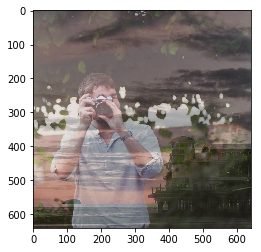

In [11]:
# Show the final merged image
plt.imshow(arr)